In [6]:

import json, os, sys, math, requests, re, random, io
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import networkx as nx
from collections import Counter


In [7]:
# Load the JSON data
with open('data/processed/deputees_17.json', 'r', encoding='utf-8') as f:
    deputies = json.load(f)

with open('data/processed/vote_17.json', 'r', encoding='utf-8') as f:
    votes = json.load(f)

print(f"Loaded {len(deputies)} deputies")
print(f"Loaded {len(votes)} votes")

Loaded 611 deputies
Loaded 3404 votes


In [8]:
G = nx.Graph()

for deputy_id, deputy_info in deputies.items():
    G.add_node(deputy_id, name=deputy_info.get('name', 'Unknown'))

print(f"Added {G.number_of_nodes()} nodes")

Added 611 nodes


In [9]:
# Track co-votes and total votes for each deputy pair
co_votes = {}  # Number of times both voted POUR together
deputy_votes = {}  # Track which votes each deputy participated in

# First pass: track which votes each deputy participated in
for vote_id, vote_data in votes.items():
    pour_voters = vote_data['votes_for']
    contre_voters = vote_data['votes_against']
    abstention_voters = vote_data['votes_abs']
    
    # All deputies who participated in this vote
    all_voters = set(pour_voters + contre_voters + abstention_voters)
    
    for deputy in all_voters:
        if deputy not in deputy_votes:
            deputy_votes[deputy] = set()
        deputy_votes[deputy].add(vote_id)
    
    # Track co-votes for POUR
    for i in range(len(pour_voters)):
        for j in range(i + 1, len(pour_voters)):
            deputy1 = pour_voters[i]
            deputy2 = pour_voters[j]
            
            if G.has_node(deputy1) and G.has_node(deputy2):
                pair = tuple(sorted([deputy1, deputy2]))
                co_votes[pair] = co_votes.get(pair, 0) + 0.5 



In [10]:
G = nx.Graph()

for deputy_id, deputy_info in deputies.items():
    G.add_node(deputy_id, name=deputy_info.get('name', 'Unknown'))
    
# Set threshold k (percentage between 0 and 1)
k = 0.3  # Deputies need to vote POUR together in at least k % of their common votes

# Second pass: create edges based on threshold
edges_added = 0
for (deputy1, deputy2), pour_count in co_votes.items():
    # Find common votes (votes both deputies participated in)
    common_votes = deputy_votes.get(deputy1, set()) & deputy_votes.get(deputy2, set())
    total_common = len(common_votes)
    
    if total_common > 0:
        percentage = pour_count / total_common
        
        if percentage >= k:
            G.add_edge(deputy1, deputy2)
            edges_added += 1

print(f"Graph created with {G.number_of_nodes()} nodes and {edges_added} edges")


Graph created with 611 nodes and 4596 edges


In [11]:
# Basic graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

# Check if graph is connected
if nx.is_connected(G):
    print("Graph is connected")
else:
    print(f"Graph has {nx.number_connected_components(G)} connected components")

Number of nodes: 611
Number of edges: 4596
Average degree: 15.04
Graph has 22 connected components


590 nodes in the giant connected component


C:\Users\tchir\AppData\Local\Temp\ipykernel_5972\1763957181.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


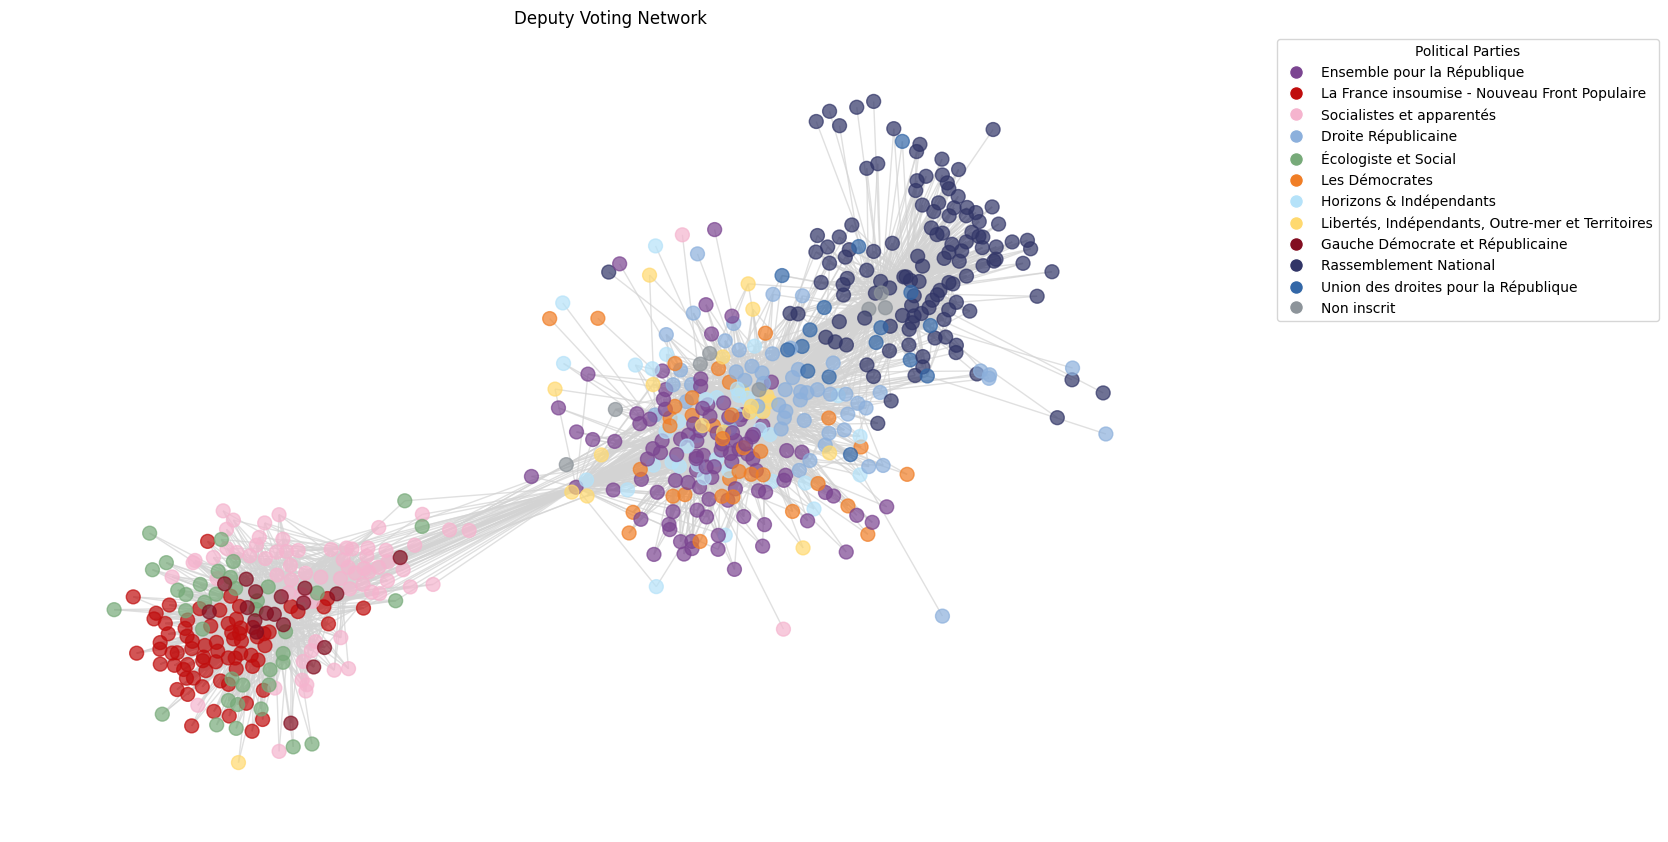

In [12]:
gcc_nodes = max(nx.connected_components(G), key=len)
GCC = G.subgraph(gcc_nodes).copy()

print(len(gcc_nodes), "nodes in the giant connected component")

nodes_color = [deputies[node].get('organ',{}).get('color','#cccccc') for node in GCC.nodes()]

party_colors = {deputies[node].get('organ',{}).get('color','#cccccc'):deputies[node].get('organ',{}).get('name','No name') for node in GCC.nodes()}



sample_nodes = list(GCC.nodes())
G_sample = GCC.subgraph(sample_nodes)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_sample, k=0.5, iterations=50)
nx.draw(G_sample, 
        pos, 
        node_size=100, node_color=nodes_color, 
        edge_color='lightgray',
        alpha=0.7, with_labels=False)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=name,
              markerfacecolor=color, markersize=10) for color, name in party_colors.items()],
           title="Political Parties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Deputy Voting Network")
plt.tight_layout()
plt.show()

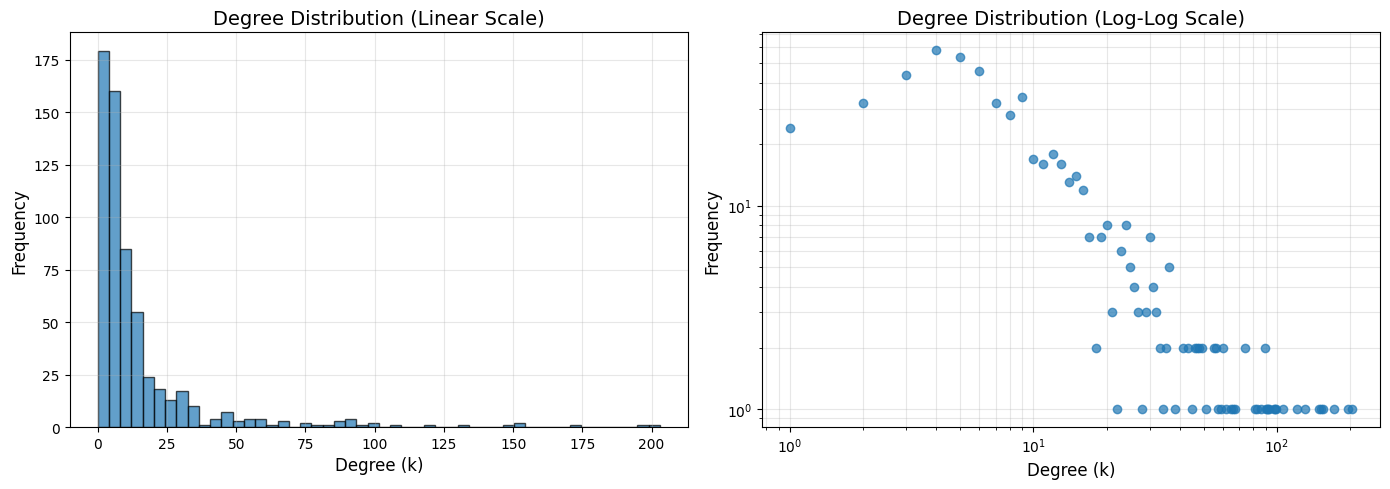

Mean degree: 15.04
Median degree: 7.00
Mode degree: 4
Min degree: 0
Max degree: 203
Standard deviation: 23.93


In [13]:
# Degree distribution
degrees = dict(G.degree())
degree_values = list(degrees.values())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].hist(degree_values, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Degree (k)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Degree Distribution (Linear Scale)', fontsize=14)
axes[0].grid(alpha=0.3)

# Log-log scale for power-law detection
degree_counts = Counter(degree_values)
ks = sorted(degree_counts.keys())
counts = [degree_counts[k] for k in ks]

axes[1].loglog(ks, counts, 'o', markersize=6, alpha=0.7)
axes[1].set_xlabel('Degree (k)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Degree Distribution (Log-Log Scale)', fontsize=14)
axes[1].grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Statistical summary
print(f"Mean degree: {np.mean(degree_values):.2f}")
print(f"Median degree: {np.median(degree_values):.2f}")
print(f"Mode degree: {max(set(degree_values), key=degree_values.count)}")
print(f"Min degree: {min(degree_values)}")
print(f"Max degree: {max(degree_values)}")
print(f"Standard deviation: {np.std(degree_values):.2f}")

In [14]:
# Calculate different centrality measures on GCC
degree_centrality = nx.degree_centrality(GCC)
betweenness_centrality = nx.betweenness_centrality(GCC)
closeness_centrality = nx.closeness_centrality(GCC)
eigenvector_centrality = nx.eigenvector_centrality(GCC, max_iter=1000)

# Top 10 Deputees by each centrality
print("\nTop 10 Deputees by Degree Centrality:")
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for i, (deputee, score) in enumerate(top_degree, 1):
    print(f"{i:2d}. {deputies[deputee].get('name',deputee):40s} {score:.4f}")

print("\nTop 10 Deputees by Betweenness Centrality:")
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for i, (deputee, score) in enumerate(top_betweenness, 1):
    print(f"{i:2d}. {deputies[deputee].get('name',deputee):40s} {score:.4f}")

print("\nTop 10 Deputees by Eigenvector Centrality:")
top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for i, (deputee, score) in enumerate(top_eigenvector, 1):
    print(f"{i:2d}. {deputies[deputee].get('name',deputee):40s} {score:.4f}")


Top 10 Deputees by Degree Centrality:
 1. Habib David                              0.3447
 2. Prevost Hugo                             0.3328
 3. Chassaigne André                         0.2920
 4. Tjibaou Emmanuel                         0.2615
 5. Grenon Daniel                            0.2564
 6. Becht Olivier                            0.2530
 7. Braun-Pivet Yaël                         0.2207
 8. Besse Véronique                          0.2054
 9. Sanquer Nicole                           0.1800
10. Provendier Remi                          0.1681

Top 10 Deputees by Betweenness Centrality:
 1. Habib David                              0.3295
 2. Prevost Hugo                             0.2596
 3. Braun-Pivet Yaël                         0.1741
 4. Grenon Daniel                            0.1143
 5. Chassaigne André                         0.0736
 6. Besse Véronique                          0.0652
 7. Becht Olivier                            0.0561
 8. Brun Philippe                

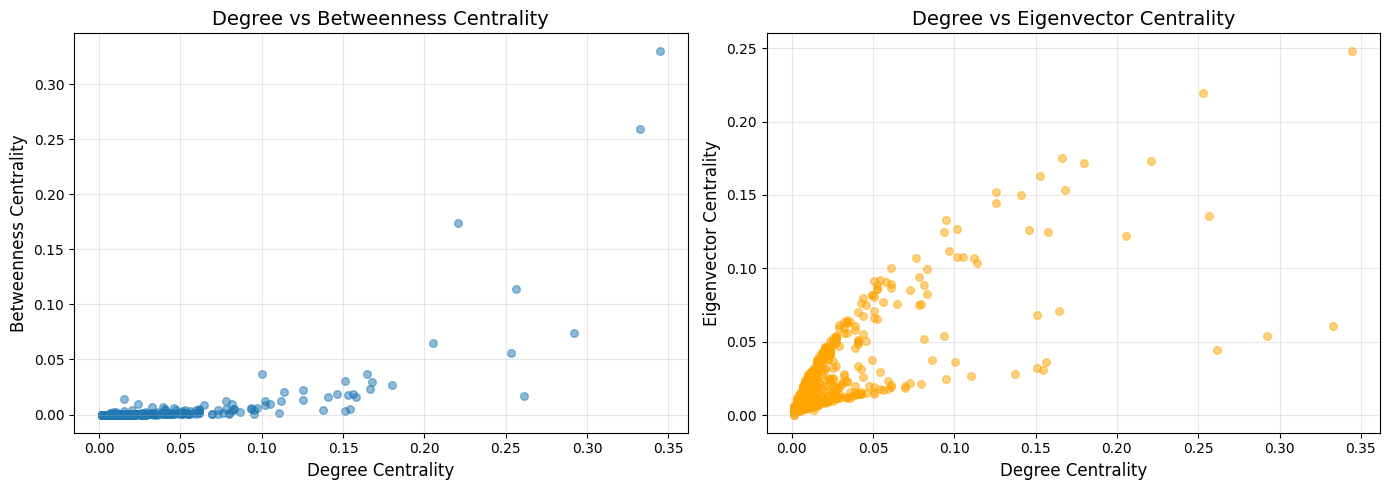

Degree vs Betweenness - Pearson: 0.706, Spearman: 0.837
Degree vs Eigenvector - Pearson: 0.754, Spearman: 0.752


In [15]:
# Compare centrality measures
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Degree vs Betweenness
deg_vals = [degree_centrality[n] for n in GCC.nodes()]
bet_vals = [betweenness_centrality[n] for n in GCC.nodes()]
axes[0].scatter(deg_vals, bet_vals, alpha=0.5, s=30)
axes[0].set_xlabel('Degree Centrality', fontsize=12)
axes[0].set_ylabel('Betweenness Centrality', fontsize=12)
axes[0].set_title('Degree vs Betweenness Centrality', fontsize=14)
axes[0].grid(alpha=0.3)

# Degree vs Eigenvector
eig_vals = [eigenvector_centrality[n] for n in GCC.nodes()]
axes[1].scatter(deg_vals, eig_vals, alpha=0.5, s=30, color='orange')
axes[1].set_xlabel('Degree Centrality', fontsize=12)
axes[1].set_ylabel('Eigenvector Centrality', fontsize=12)
axes[1].set_title('Degree vs Eigenvector Centrality', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlations
from scipy.stats import spearmanr, pearsonr

pearson_deg_bet, p_deg_bet = pearsonr(deg_vals, bet_vals)
spearman_deg_bet, _ = spearmanr(deg_vals, bet_vals)

pearson_deg_eig, p_deg_eig = pearsonr(deg_vals, eig_vals)
spearman_deg_eig, _ = spearmanr(deg_vals, eig_vals)

print(f"Degree vs Betweenness - Pearson: {pearson_deg_bet:.3f}, Spearman: {spearman_deg_bet:.3f}")
print(f"Degree vs Eigenvector - Pearson: {pearson_deg_eig:.3f}, Spearman: {spearman_deg_eig:.3f}")

Degree Assortativity Coefficient: -0.4310
→ Network is DISASSORTATIVE: High-degree nodes tend to connect to low-degree nodes


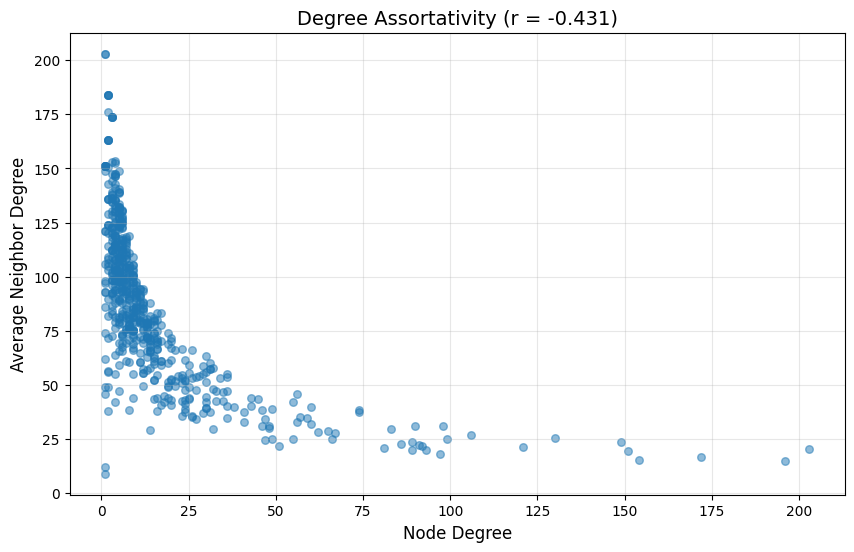

In [16]:
# Degree assortativity
degree_assortativity = nx.degree_assortativity_coefficient(GCC)
print(f"Degree Assortativity Coefficient: {degree_assortativity:.4f}")

if degree_assortativity > 0:
    print("→ Network is ASSORTATIVE: High-degree nodes tend to connect to other high-degree nodes")
else:
    print("→ Network is DISASSORTATIVE: High-degree nodes tend to connect to low-degree nodes")

# Average neighbor degree
avg_neighbor_degree = nx.average_neighbor_degree(GCC)

# Visualize assortativity
node_degrees = [GCC.degree(n) for n in GCC.nodes()]
avg_neighbor_degrees = [avg_neighbor_degree[n] for n in GCC.nodes()]

plt.figure(figsize=(10, 6))
plt.scatter(node_degrees, avg_neighbor_degrees, alpha=0.5, s=30)
plt.xlabel('Node Degree', fontsize=12)
plt.ylabel('Average Neighbor Degree', fontsize=12)
plt.title(f'Degree Assortativity (r = {degree_assortativity:.3f})', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

In [17]:
import sys, warnings
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
from scipy.stats import binom

def disparity_filter(table, undirected = False, return_self_loops = False):
   sys.stderr.write("Calculating DF score...\n")
   table = table.copy()
   table_sum = table.groupby(table["src"]).sum().reset_index()
   table_deg = table.groupby(table["src"]).count()["trg"].reset_index()
   table = table.merge(table_sum, on = "src", how = "left", suffixes = ("", "_sum"))
   table = table.merge(table_deg, on = "src", how = "left", suffixes = ("", "_count"))
   table["score"] = 1.0 - ((1.0 - (table["nij"] / table["nij_sum"])) ** (table["trg_count"] - 1))
   table["variance"] = (table["trg_count"] ** 2) * (((20 + (4.0 * table["trg_count"])) / ((table["trg_count"] + 1.0) * (table["trg_count"] + 2) * (table["trg_count"] + 3))) - ((4.0) / ((table["trg_count"] + 1.0) ** 2)))
   if not return_self_loops:
      table = table[table["src"] != table["trg"]]
   if undirected:
      table["edge"] = table.apply(lambda x: "%s-%s" % (min(x["src"], x["trg"]), max(x["src"], x["trg"])), axis = 1)
      table_maxscore = table.groupby(by = "edge")["score"].max().reset_index()
      table_minvar = table.groupby(by = "edge")["variance"].min().reset_index()
      table = table.merge(table_maxscore, on = "edge", suffixes = ("_min", ""))
      table = table.merge(table_minvar, on = "edge", suffixes = ("_max", ""))
      table = table.drop_duplicates(subset = ["edge"])
      table = table.drop("edge", axis=1)
      table = table.drop("score_min", axis=1)
      table = table.drop("variance_max", axis=1)
   return table[["src", "trg", "nij", "score", "variance"]]

def high_salience_skeleton(table, undirected = False, return_self_loops = False):
   sys.stderr.write("Calculating HSS score...\n")
   table = table.copy()
   table["distance"] = 1.0 / table["nij"]
   nodes = set(table["src"]) | set(table["trg"])
   G = nx.from_pandas_edgelist(table, source = "src", target = "trg", edge_attr = "distance", create_using = nx.DiGraph())
   cs = defaultdict(float)
   for s in nodes:
      pred = defaultdict(list)
      dist = {t: float("inf") for t in nodes}
      dist[s] = 0.0
      Q = defaultdict(list)
      for w in dist:
         Q[dist[w]].append(w)
      S = []
      while len(Q) > 0:
         v = Q[min(Q.keys())].pop(0)
         S.append(v)
         for _, w, l in G.edges(nbunch = [v,], data = True):
            new_distance = dist[v] + l["distance"]
            if dist[w] > new_distance:
               Q[dist[w]].remove(w)
               dist[w] = new_distance
               Q[dist[w]].append(w)
               pred[w] = []
            if dist[w] == new_distance:
               pred[w].append(v)
         while len(S) > 0:
            w = S.pop()
            for v in pred[w]:
               cs[(v, w)] += 1.0
         Q = defaultdict(list, {k: v for k, v in Q.items() if len(v) > 0})
   table["score"] = table.apply(lambda x: cs[(x["src"], x["trg"])] / len(nodes), axis = 1)
   if not return_self_loops:
      table = table[table["src"] != table["trg"]]
   if undirected:
      table["edge"] = table.apply(lambda x: "%s-%s" % (min(x["src"], x["trg"]), max(x["src"], x["trg"])), axis = 1)
      table_maxscore = table.groupby(by = "edge")["score"].sum().reset_index()
      table = table.merge(table_maxscore, on = "edge", suffixes = ("_min", ""))
      table = table.drop_duplicates(subset = ["edge"])
      table = table.drop("edge", axis=1)
      table = table.drop("score_min", axis=1)
      table["score"] = table["score"] / 2.0
   return table[["src", "trg", "nij", "score"]]

def thresholding(table, threshold):
   """Reads a preprocessed edge table and returns only the edges supassing a significance threshold.

   Args:
   table (pandas.DataFrame): The edge table.
   threshold (float): The minimum significance to include the edge in the backbone.

   Returns:
   The network backbone.
   """
   table = table.copy()
   if "sdev_cij" in table:
      return table[(table["score"] - (threshold * table["sdev_cij"])) > 0][["src", "trg", "nij", "score"]]
   else:
      return table[table["score"] > threshold][["src", "trg", "nij", "score"]]

In [18]:
# Calculate edge betweenness for backbone
edge_betweenness = nx.edge_betweenness_centrality(GCC)

# Normalize edge weights (1 to 100 scale)
values = list(edge_betweenness.values())
min_val, max_val = min(values), max(values)

# Create weighted graph
weighted_edges = [
    (u, v, 1 + 99 * (weight - min_val) / (max_val - min_val))
    for (u, v), weight in edge_betweenness.items()
]

G_weighted = GCC.copy()
G_weighted.clear_edges()
G_weighted.add_weighted_edges_from(weighted_edges)

# Extract backbone using disparity filter
df_edges = nx.to_pandas_edgelist(G_weighted, source='src', target='trg')
df_edges.rename(columns={'weight': 'nij'}, inplace=True)

# Apply disparity filter (using the function from your notebook)
df_filtered = disparity_filter(df_edges, undirected=True)

# Apply threshold
backbone_edges = thresholding(df_filtered, threshold=0.5)
print(f"Original network edges: {GCC.number_of_edges()}")
print(f"Backbone network edges: {len(backbone_edges)} ({100*len(backbone_edges)/GCC.number_of_edges():.1f}%)")

# Create backbone graph
G_backbone = nx.from_pandas_edgelist(backbone_edges, source='src', target='trg')
G_backbone = G_backbone.subgraph([n for n in G_backbone.nodes() if G_backbone.degree(n) > 0]).copy()

print(f"Backbone nodes: {G_backbone.number_of_nodes()}")
print(f"Backbone components: {nx.number_connected_components(G_backbone)}")

Original network edges: 4596
Backbone network edges: 4246 (92.4%)
Backbone nodes: 572
Backbone components: 1


Calculating DF score...


{'PA1592': 'Habib David', 'PA841167': 'Prevost Hugo', 'PA721908': 'Braun-Pivet Yaël', 'PA795540': 'Grenon Daniel', 'PA267306': 'Chassaigne André', 'PA642935': 'Becht Olivier', 'PA793624': 'Brun Philippe', 'PA309643': 'Besse Véronique', 'PA720668': 'Blairy Emmanuel', 'PA842323': 'Provendier Remi', 'PA840721': 'Chavent Marc', 'PA870010': 'Martin Sébastien', 'PA721110': 'Sanquer Nicole', 'PA606793': 'Baumel Laurent', 'PA796078': 'Youssouffa Estelle'}


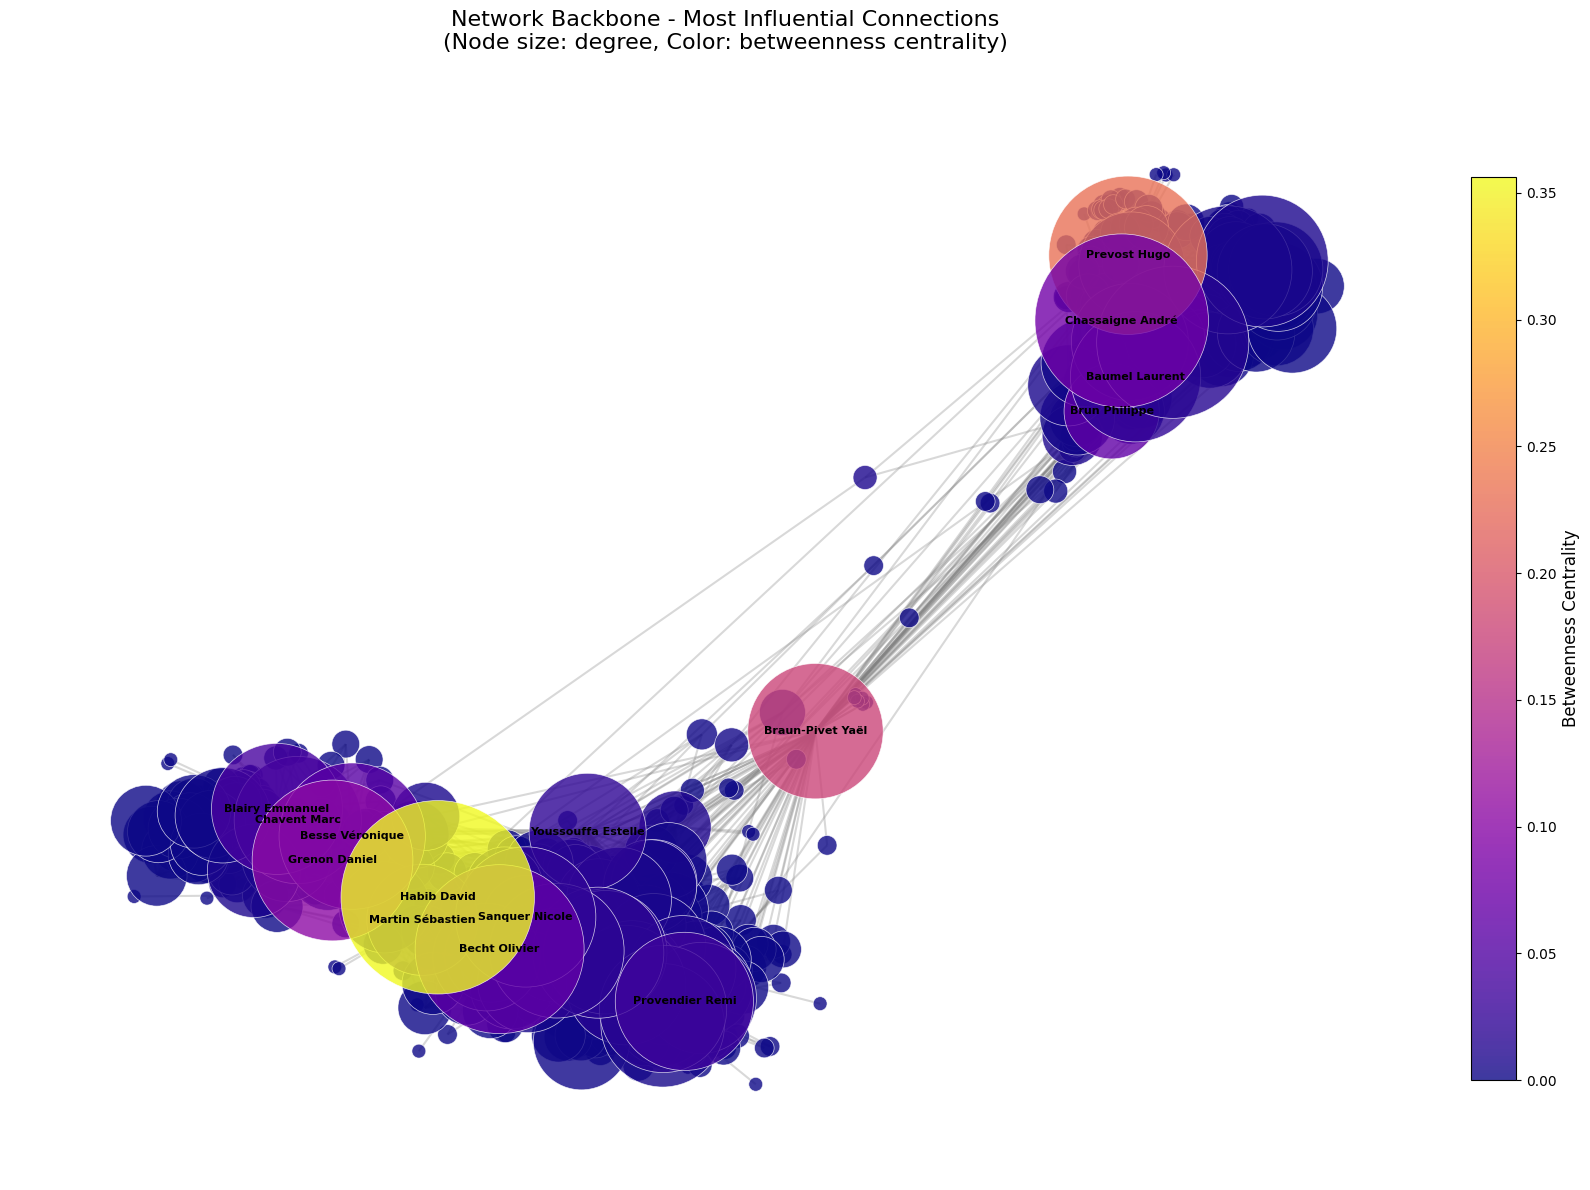

In [19]:
# Visualize the backbone
pos = nx.forceatlas2_layout(G_backbone)

# Size nodes by degree in backbone
backbone_degrees = dict(G_backbone.degree())
node_sizes = [backbone_degrees[n] * 100 for n in G_backbone.nodes()]

# Color by betweenness centrality in backbone
backbone_betweenness = nx.betweenness_centrality(G_backbone)
node_colors = [backbone_betweenness[n] for n in G_backbone.nodes()]

fig, ax = plt.subplots(figsize=(16, 12))

# Sort nodes by size (smallest first, so largest drawn last/on top)
nodes_list = list(G_backbone.nodes())
sorted_indices = np.argsort(node_sizes)
sorted_nodes = [nodes_list[i] for i in sorted_indices]
sorted_sizes = [node_sizes[i] for i in sorted_indices]
sorted_colors = [backbone_betweenness[n] for n in sorted_nodes]

nodes = nx.draw_networkx_nodes(
    G_backbone, pos, 
    nodelist=sorted_nodes,
    node_size=sorted_sizes,
    node_color=sorted_colors,
    cmap=plt.cm.plasma,
    alpha=0.8,
    edgecolors='white',
    linewidths=0.5,
    ax=ax
)


nx.draw_networkx_edges(
    G_backbone, pos, ax=ax,
    alpha=0.3,
    width=1.5,
    edge_color='gray'
)

# Add labels for top nodes
top_nodes = sorted(backbone_betweenness.items(), key=lambda x: x[1], reverse=True)[:15]
labels = {node: deputies[node].get('name',node) for node, _ in top_nodes}
print(labels)
nx.draw_networkx_labels(
    G_backbone, pos,
    labels=labels,
    font_size=8,
    font_weight='bold',
    ax=ax
)

ax.set_title("Network Backbone - Most Influential Connections\n(Node size: degree, Color: betweenness centrality)", 
             fontsize=16, pad=20)
ax.axis('off')

cbar = plt.colorbar(nodes, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label('Betweenness Centrality', fontsize=12)

plt.tight_layout()
plt.show()

In [20]:
# Average shortest path length
avg_path_length = nx.average_shortest_path_length(GCC)
print(f"Average shortest path length: {avg_path_length:.3f}")

# Clustering coefficient
avg_clustering = nx.average_clustering(GCC)
print(f"Average clustering coefficient: {avg_clustering:.3f}")

# Compare with random graph
n = GCC.number_of_nodes()
m = GCC.number_of_edges()
p = (2 * m) / (n * (n - 1))

G_random = nx.erdos_renyi_graph(n, p, seed=42)
random_path = nx.average_shortest_path_length(G_random)
random_clustering = nx.average_clustering(G_random)

print(f"\nRandom graph comparison (same n, p):")
print(f"  Random avg path length: {random_path:.3f}")
print(f"  Random avg clustering: {random_clustering:.3f}")

print(f"\nSmall-world coefficient:")
print(f"  Path length ratio (actual/random): {avg_path_length/random_path:.3f}")
print(f"  Clustering ratio (actual/random): {avg_clustering/random_clustering:.3f}")

if avg_clustering > random_clustering and avg_path_length < 1.5 * random_path:
    print("Network exhibits SMALL-WORLD properties!")

Average shortest path length: 2.723
Average clustering coefficient: 0.594

Random graph comparison (same n, p):
  Random avg path length: 2.630
  Random avg clustering: 0.026

Small-world coefficient:
  Path length ratio (actual/random): 1.035
  Clustering ratio (actual/random): 22.825
Network exhibits SMALL-WORLD properties!


## Communities

C:\Users\tchir\AppData\Local\Temp\ipykernel_5972\1980068401.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities) if num_communities <= 10 else plt.cm.get_cmap('viridis', num_communities)
C:\Users\tchir\AppData\Local\Temp\ipykernel_5972\1980068401.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


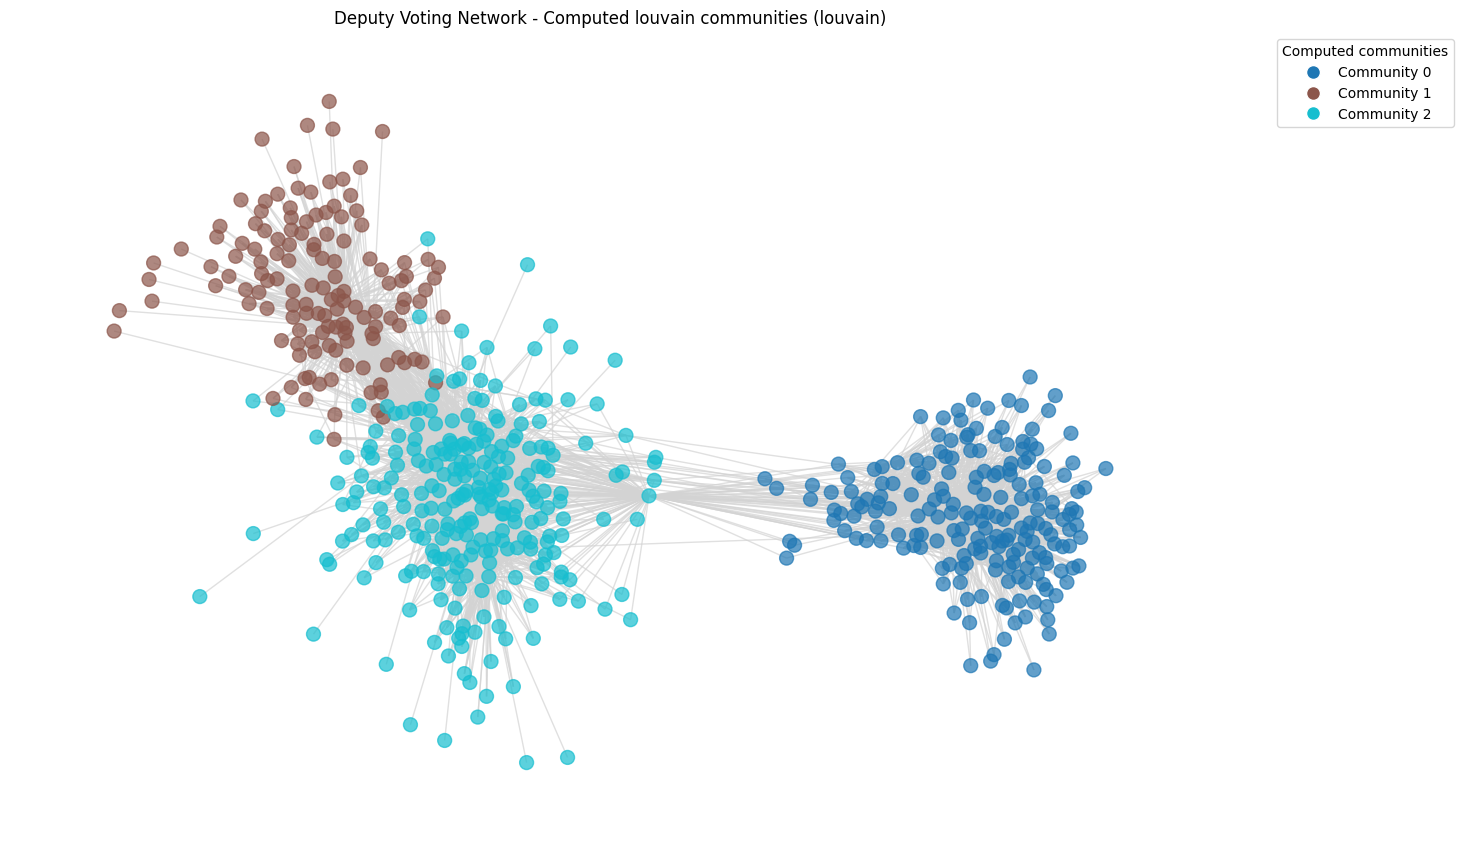

C0 : Prevost Hugo , La France insoumise - Nouveau Front Populaire
{'name': 'Prevost Hugo', 'chair_numbers': ['640'], 'organ': {'id': 'PO845413', 'name': 'La France insoumise - Nouveau Front Populaire', 'name_from': 'du groupe La France insoumise - Nouveau Front Populaire', 'name_short': 'LFI-NFP', 'color': '#C00D0D'}, 'speeches': []}
C1 : Bazin Thibault , Droite Républicaine
{'name': 'Bazin Thibault', 'chair_numbers': ['165'], 'organ': {'id': 'PO845425', 'name': 'Droite Républicaine', 'name_from': 'du groupe Droite Républicaine', 'name_short': 'DR', 'color': '#8CB0DC'}, 'speeches': []}
C2 : Galliard-Minier Camille , Ensemble pour la République
{'name': 'Galliard-Minier Camille', 'chair_numbers': ['320', '308', '301'], 'organ': {'id': 'PO845407', 'name': 'Ensemble pour la République', 'name_from': 'du groupe Ensemble pour la République', 'name_short': 'EPR', 'color': '#7B4591'}, 'speeches': []}


In [42]:
communities_set = nx.community.louvain_communities(G_sample)
num_communities = len(communities_set)

partition = {}
for community_id, nodes in enumerate(communities_set):
    for node in nodes:
        partition[node] = community_id

cmap = plt.cm.get_cmap('tab10', num_communities) if num_communities <= 10 else plt.cm.get_cmap('viridis', num_communities)

# --- This is the list for node_color ---
nodes_color_com = [cmap(partition[node]) for node in G_sample.nodes()]

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Community {i}', markerfacecolor=cmap(i), markersize=10) for i in range(num_communities)]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_sample, k=0.5, iterations=50)
nx.draw(G_sample, 
        pos, 
        node_size=100, node_color=nodes_color_com, 
        edge_color='lightgray',
        alpha=0.7, with_labels=False)
plt.legend(handles=legend_handles,
           title="Computed communities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Deputy Voting Network - Computed louvain communities (louvain)")
plt.tight_layout()
plt.show()

for i, community in enumerate(communities_set):
      print(f"C{i} : {deputies[list(community)[0]].get('name')} , {deputies[list(community)[0]]['organ']['name']}")
      print(deputies[list(community)[0]])

In [81]:
organ_name_dict = {}
for dep in list(deputies.keys()):
    organ_id = deputies[dep]['organ']['id']
    organ_name = deputies[dep]['organ']['name']
    organ_short_name = deputies[dep]['organ']['name_short']
    if organ_id not in organ_name_dict:

        organ_name_dict[organ_id] = (organ_name, organ_short_name)

In [67]:
communities_dict = {}
for i,comm in enumerate(list(communities_set)):
    communities_dict[f"C{i}"] = comm

print(list(communities_dict.values()))

[{'PA841167', 'PA774962', 'PA842271', 'PA841223', 'PA793816', 'PA608172', 'PA720838', 'PA608264', 'PA795362', 'PA841471', 'PA606573', 'PA793708', 'PA841463', 'PA2940', 'PA610654', 'PA722142', 'PA796010', 'PA841215', 'PA794146', 'PA793444', 'PA841243', 'PA841813', 'PA721896', 'PA795430', 'PA840793', 'PA342415', 'PA719930', 'PA791824', 'PA841853', 'PA794710', 'PA841893', 'PA795076', 'PA796070', 'PA795310', 'PA795616', 'PA795164', 'PA1008', 'PA840765', 'PA796062', 'PA794082', 'PA793980', 'PA610002', 'PA721210', 'PA340343', 'PA841515', 'PA342384', 'PA841327', 'PA795636', 'PA793756', 'PA793736', 'PA795298', 'PA795454', 'PA793912', 'PA841251', 'PA1654', 'PA793452', 'PA841681', 'PA841717', 'PA609332', 'PA842037', 'PA795746', 'PA841107', 'PA795240', 'PA643143', 'PA840903', 'PA333285', 'PA796018', 'PA840939', 'PA794022', 'PA841919', 'PA1567', 'PA841633', 'PA335999', 'PA826635', 'PA842299', 'PA795228', 'PA342196', 'PA841367', 'PA794270', 'PA793464', 'PA795762', 'PA795084', 'PA841947', 'PA720892'

In [58]:
partis_members = {}
    
for id_member, data_member in deputies.items():
    # Récupère l'ID du parti
    id_parti = data_member['organ']['id']
    if id_parti in partis_members:
        partis_members[id_parti].append(id_member)
    else:
        partis_members[id_parti] = [id_member]

print(partis_members)

{'PO845407': ['PA795050', 'PA795958', 'PA795144', 'PA759832', 'PA718674', 'PA719372', 'PA795990', 'PA795884', 'PA721024', 'PA721908', 'PA722382', 'PA2960', 'PA720446', 'PA795950', 'PA335758', 'PA719798', 'PA795864', 'PA721158', 'PA719472', 'PA795386', 'PA720154', 'PA721916', 'PA794802', 'PA643184', 'PA642935', 'PA795664', 'PA720022', 'PA345722', 'PA719388', 'PA721852', 'PA722190', 'PA795920', 'PA720342', 'PA721750', 'PA721296', 'PA841709', 'PA795962', 'PA794798', 'PA267200', 'PA719338', 'PA842147', 'PA721134', 'PA817203', 'PA721426', 'PA720066', 'PA795528', 'PA719756', 'PA719632', 'PA721004', 'PA719890', 'PA842311', 'PA840235', 'PA722366', 'PA721764', 'PA719550', 'PA721584', 'PA607395', 'PA841927', 'PA720354', 'PA717379', 'PA795722', 'PA719404', 'PA793416', 'PA722102', 'PA720146', 'PA677483', 'PA793270', 'PA642695', 'PA606507', 'PA712014', 'PA720370', 'PA794330', 'PA719922', 'PA795908', 'PA794982', 'PA721170', 'PA841601', 'PA719412', 'PA795730', 'PA794206', 'PA722000', 'PA793940', 'PA7

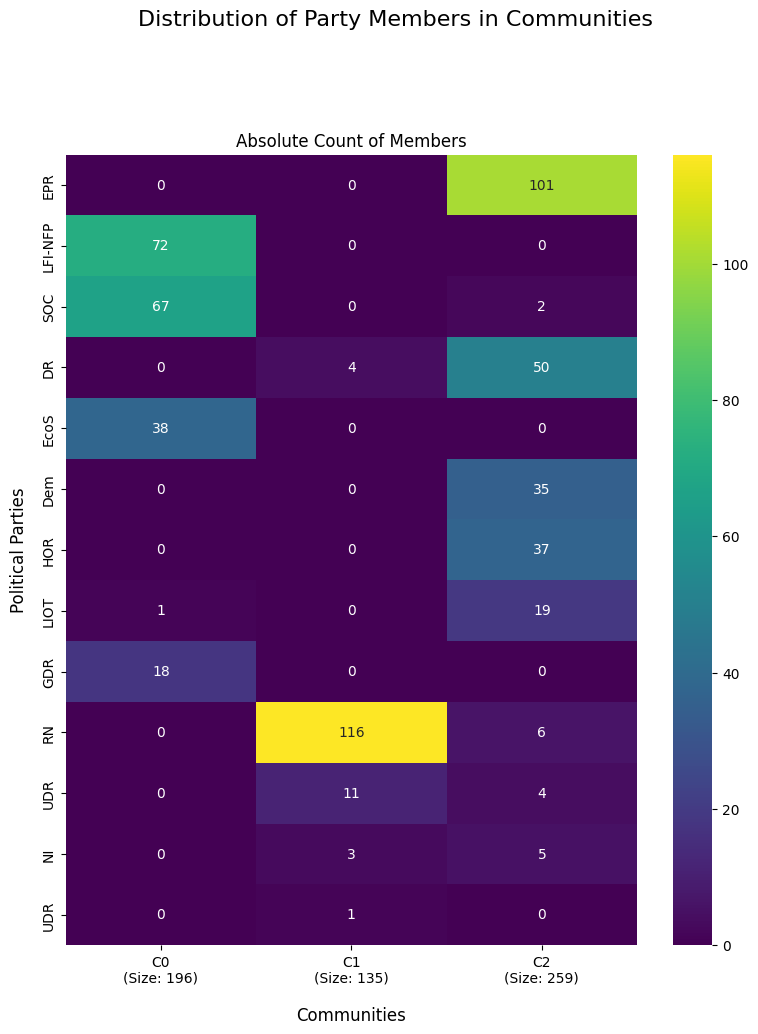

Community Key:
C0 : (Size: 196)
C1 : (Size: 135)
C2 : (Size: 259)


In [82]:
def calculate_matrix_D(dict_partis, dict_commu_raw, all_member_ids, norm_vertical=True, plot=True):

    # --- NEW LOGIC: Parse the raw frozenset dict ---
    # Convert the raw frozenset dictionary into the (name, [members]) tuple format
    community_tuples = [] # This will be [(comm_key, [members]), ...]
    
    # Sort by key (C0, C1, ...) to ensure consistent order
    sorted_comm_keys = sorted(dict_commu_raw.keys()) 
    
    for comm_key in sorted_comm_keys:
        comm_set = dict_commu_raw[comm_key]
        members_in_comm = []
        # comm_name = None # <-- REMOVED
        
        # --- MODIFIED LOGIC ---
        # Only extract member IDs
        for item in comm_set:
            if item in all_member_ids:
                members_in_comm.append(item)
            # else:
                # We no longer care about the string name
                # comm_name = item # <-- REMOVED
                
        # if comm_name is None:
        #     comm_name = f"Unnamed {comm_key}" # Fallback # <-- REMOVED
            
        # Store the KEY (C0, C1...) as the "name"
        community_tuples.append((comm_key, members_in_comm))
    # --- END NEW LOGIC ---
    
    
    # Get the lists of party members and community tuples
    # We rely on the list order being consistent
    party_member_lists = list(dict_partis.values())
    # community_tuples = list(dict_commu.values()) # [(name, [members]), ...] <-- This line is replaced by the logic above
    
    num_parti = len(party_member_lists)
    num_commu = len(community_tuples)
    
    D = np.empty(shape=(num_parti, num_commu))

    for i in range(0, num_parti):  # Iterate over parties (rows)
        party_i_members = party_member_lists[i]
        
        for j in range(0, num_commu): # Iterate over communities (columns)
            community_j_tuple = community_tuples[j]
            community_j_members = community_j_tuple[1] # Get the member list (index 1)
            
            # --- FIX 1: Corrected intersection logic ---
            # Find members from community j that are also in party i
            intersection = [d for d in community_j_members if d in party_i_members]
            D[i, j] = len(intersection)
            # --- End of FIX 1 ---

            if norm_vertical:
                num_community_members = len(community_j_members)
                if num_community_members > 0: # Évite la division par zéro
                    D[i, j] *= 100 / num_community_members
                else:
                    D[i, j] = 0 # Communauté vide

    if plot:
        # Axes X (Columns) and Y (Lines) : Communitie and genre names
        
        # --- MODIFIED X_LABELS ---
        # x_labels now uses community_tuple[0] (which is C0, C1, etc.)
        x_labels = [f"{community_tuple[0]}\n(Size: {len(community_tuple[1])})" for j, community_tuple in enumerate(community_tuples)]
        
        # --- FIX 2: y_labels now uses keys from dict_partis ---
        y_labels = [organ_name_dict[g][1] for g in list(dict_partis.keys())]
        # --- End of FIX 2 ---
        
        fig_width = max(8, num_commu * 2.5) 
        fig_height = max(6, num_parti * 0.8)
        
        plt.figure(figsize=(fig_width, fig_height)) 
        
        sns.heatmap(
            D,
            annot=True,          # Show the numbers in each bloc
            fmt='.0f',           # Format as int
            cmap='viridis',      # Color (Blue=Weak, Yellow=Strong)
            xticklabels=x_labels,
            yticklabels=y_labels
        )
        plt.suptitle('Distribution of Party Members in Communities', fontsize=16, y=1.02)
        if norm_vertical:
            plt.title(f'Normalized by Community Size (%)')
        else:
            plt.title(f'Absolute Count of Members')
            
        plt.xlabel('Communities', fontsize=12, labelpad=15)
        plt.ylabel('Political Parties', fontsize=12, labelpad=10)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
        plt.show()
        
        print("Community Key:")
        # --- FIX 3: Iterate over values (tuples) to print names ---
        for i, community_tuple in enumerate(community_tuples):
            # Print key (index 0) and size
            print(f'{community_tuple[0]} : (Size: {len(community_tuple[1])})')
        # --- End of FIX 3 ---
            
    return D

matrix_D = calculate_matrix_D(
    partis_members,       
    communities_dict, 
    plot=True,
    norm_vertical=False,
    all_member_ids = set(deputies.keys())
)